## Crop objects from CLEVRER Vidoes automatically

In [10]:
from PIL import Image
import json
from pycocotools import mask
import matplotlib.pyplot as plt
import numpy as np
import os
import subprocess

In [2]:
def mean_center_of_mask(mask):
    # Get the coordinates of all non-zero pixels (foreground pixels)
    foreground_pixels = np.column_stack(np.where(mask == 1))

    if foreground_pixels.shape[0] == 0:
        return None  # Return None if there are no foreground pixels

    # Calculate the mean center (centroid) by averaging the coordinates
    mean_y = int(
        np.round(np.mean(foreground_pixels[:, 0]))
    )  # Mean of y-coordinates (rows)
    mean_x = int(
        np.round(np.mean(foreground_pixels[:, 1]))
    )  # Mean of x-coordinates (columns)

    return mean_x, mean_y  # Return the (x, y) coordinates of the centroid


def crop_images_around_object(
    image_filenames: list[str],
    object_attributes: dict,
    derender: dict,
    target_folder: str,
    cropped_img_size=128,
):
    derender_frames = derender["frames"]
    padding_size = int(np.ceil(cropped_img_size / 2))

    for i, frame_dict in enumerate(derender_frames):
        objects_in_frame = frame_dict["objects"]
        video_frame = np.array(Image.open(image_filenames[i]))
        for ob in objects_in_frame:
            ob_attributes = {key: ob[key] for key in object_attributes.keys()}
            if ob_attributes == object_attributes:
                binary_mask = mask.decode(ob["mask"])
                mask_center = mean_center_of_mask(binary_mask)

                padded_video_frame = np.pad(
                    video_frame,
                    (
                        (padding_size, padding_size),
                        (padding_size, padding_size),
                        (0, 0),
                    ),
                    mode="reflect",
                )
                cropped_img = padded_video_frame[
                    mask_center[1] : mask_center[1] + 2 * padding_size,
                    mask_center[0] : mask_center[0] + 2 * padding_size,
                    :,
                ]
                Image.fromarray(cropped_img).save(
                    os.path.join(target_folder, os.path.basename(image_filenames[i]))
                )
                break

In [3]:
# declare video_id
video_id = 10001

# setup paths based on video id
video_path = f"/app/clevrer_videos/video_{video_id}.mp4"
derender_proposal_path = f"/app/derender_proposals/proposal_{video_id}.json"
base_path_video_frames = f"/app/ncb/edited_videos/video_{video_id}/video_frames"
target_folder = f"/app/ncb/square_imgs/video_{video_id}"

# create frames from video
os.makedirs(base_path_video_frames, exist_ok=True)
os.makedirs(target_folder, exist_ok=True)
command = f"cd {os.path.dirname(video_path)} && ffmpeg -i {os.path.basename(video_path)} -q:v 2 -start_number 0 {base_path_video_frames}/'%05d.jpg'"
subprocess.run(command, shell=True)

# load frame names into list
frame_names = [
    os.path.join(base_path_video_frames, frame_name)
    for frame_name in sorted(os.listdir(base_path_video_frames))
]

# open scene description
with open(derender_proposal_path) as file:
    derender_dict = json.load(file)

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [4]:
# define object attributes to track
object_attributes = {
    "color": "blue",
    "material": "metal",
    "shape": "cylinder",
}

# crop images
crop_images_around_object(frame_names, object_attributes, derender_dict, target_folder)

frame 36


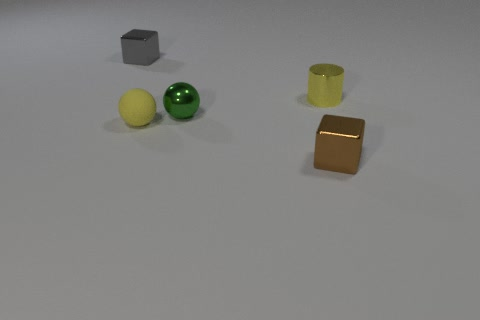

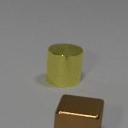

In [5]:
# test result at random
frame_id = np.random.randint(0, len(frame_names))
print(f"frame {frame_id}")
Image.open(os.path.join(base_path_video_frames, f"{frame_id:05d}.jpg")).show()
Image.open(os.path.join(target_folder, f"{frame_id:05d}.jpg")).show()

## Manually crop a single image

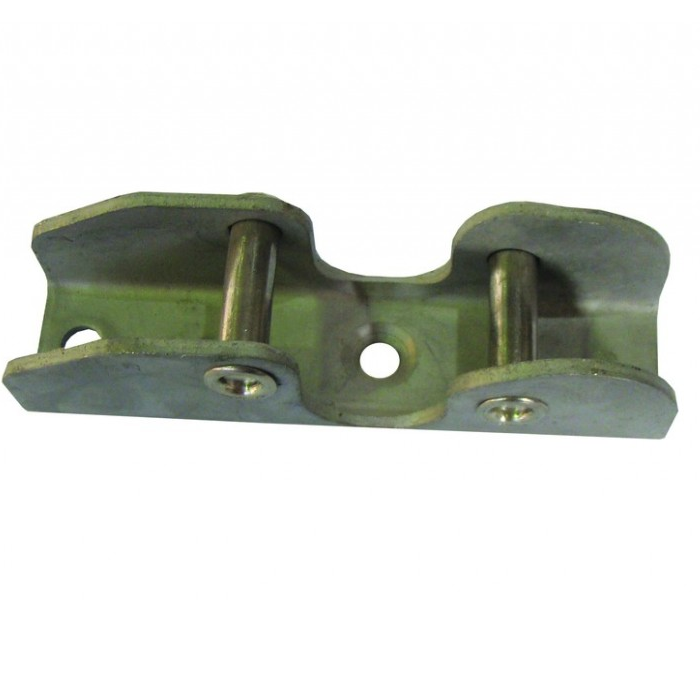

In [6]:
# manual image cropping on single images
img = np.array(Image.open("/app/ncb/test_images/Gegenhalter Krone oben 515000704.jpg"))
padding_size = 100
img = Image.fromarray(
    np.pad(
        img,
        pad_width= (
            (padding_size, padding_size),
            (0, 0),
            (0, 0),
        ),
        mode="constant",
        constant_values=255,
    )
)
# img.show()
offset = 700
x, y = 260, 100
img = img.crop((x, y, x + offset, y + offset))
img.show()
img.save("/app/ncb/square_imgs/test_images/Gegenhalter_Krone.jpg")

## Downsize images and put them all in a single folder

In [10]:
import os
import shutil

# Source directory (folder with subfolders containing images)
source_dir = "/app/ncb/car_parts_40/car_parts_50/train"

# Destination directory (where all images will be copied)
destination_dir = "/app/ncb/car_parts_40/car_parts_50/all_train_imgs"

# Ensure the destination directory exists
os.makedirs(destination_dir, exist_ok=True)

# Supported image file extensions
image_extensions = (".jpg")

# Walk through all subfolders and files
for root, _, files in os.walk(source_dir):
    for file in files:
        if file.lower().endswith(image_extensions):  # Check if file is an image
            source_path = os.path.join(root, file)  # Full path to the image
            destination_path = os.path.join(destination_dir, file)
            
            # Avoid overwriting files with the same name
            counter = 1
            while os.path.exists(destination_path):
                name, ext = os.path.splitext(file)
                new_filename = f"{name}_{counter}{ext}"
                destination_path = os.path.join(destination_dir, new_filename)
                counter += 1
            
            # Copy the image to the destination folder
            shutil.copy2(source_path, destination_path)
            # print(f"Copied: {source_path} -> {destination_path}")

print("All images have been copied.")



All images have been copied.


## Explode packaging videos into frames

In [16]:
import os
import subprocess

def explode_video_into_frames(video_base_path: str, video_name: str):
    # setup paths based on video id
    video_path = os.path.join(video_base_path, f"{video_name}.mp4")
    base_path_video_frames = f"/app/packtisch/frames/{video_name}"

    # create frames from video
    os.makedirs(base_path_video_frames, exist_ok=True)
    command = f"cd {os.path.dirname(video_path)} && ffmpeg -i {os.path.basename(video_path)} -q:v 2 -start_number 0 -vf 'scale=-1:250' -loglevel quiet {base_path_video_frames}/'%04d.jpg'"
    subprocess.run(command, shell=True)

video_base_path = "/app/packtisch/neue_videos"
video_names = sorted(os.listdir(video_base_path))
video_names = [vid_name.split(".")[0] for vid_name in video_names]
[explode_video_into_frames(video_base_path, vid_name) for vid_name in video_names]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

## Pick adequate frames for classification

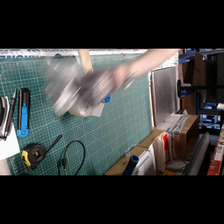

/app/packtisch/square_frames/2024-09-23_14-17-19_cam2/0000.png


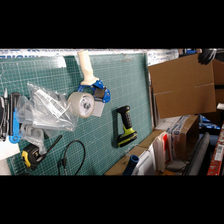

/app/packtisch/square_frames/2024-09-23_14-17-19_cam2/0100.png


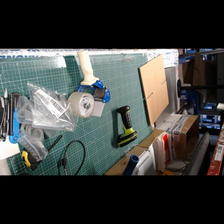

/app/packtisch/square_frames/2024-09-23_14-17-19_cam2/0200.png


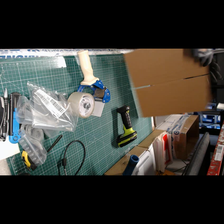

/app/packtisch/square_frames/2024-09-23_14-17-19_cam2/0300.png


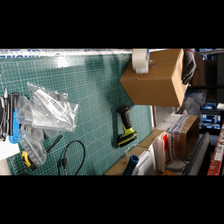

/app/packtisch/square_frames/2024-09-23_14-17-19_cam2/0400.png


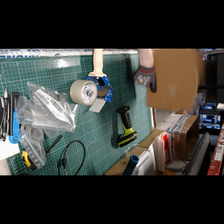

/app/packtisch/square_frames/2024-09-23_14-17-19_cam2/0500.png


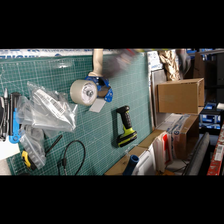

/app/packtisch/square_frames/2024-09-23_14-17-19_cam2/0600.png


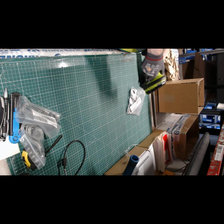

/app/packtisch/square_frames/2024-09-23_14-17-19_cam2/0700.png


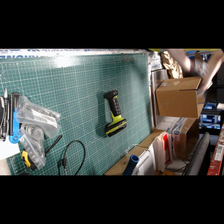

/app/packtisch/square_frames/2024-09-23_14-17-19_cam2/0800.png


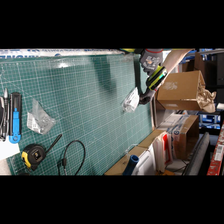

/app/packtisch/square_frames/2024-09-23_14-17-19_cam2/0900.png


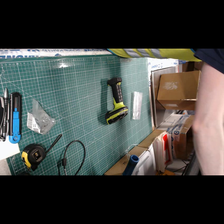

/app/packtisch/square_frames/2024-09-23_14-17-19_cam2/1000.png


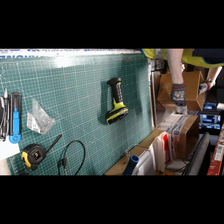

/app/packtisch/square_frames/2024-09-23_14-17-19_cam2/1100.png


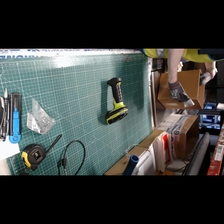

/app/packtisch/square_frames/2024-09-23_14-17-19_cam2/1200.png


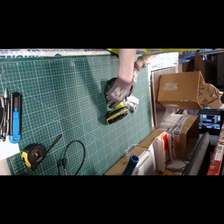

/app/packtisch/square_frames/2024-09-23_14-17-19_cam2/1300.png


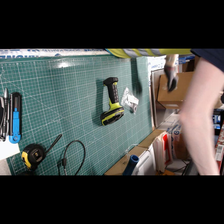

/app/packtisch/square_frames/2024-09-23_14-17-19_cam2/1400.png


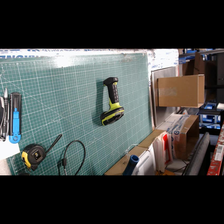

/app/packtisch/square_frames/2024-09-23_14-17-19_cam2/1500.png


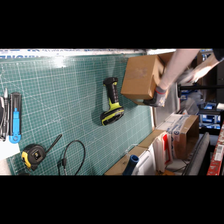

/app/packtisch/square_frames/2024-09-23_14-17-19_cam2/1600.png


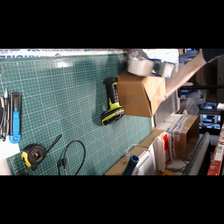

/app/packtisch/square_frames/2024-09-23_14-17-19_cam2/1700.png


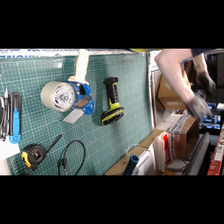

/app/packtisch/square_frames/2024-09-23_14-17-19_cam2/1800.png


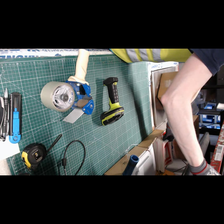

/app/packtisch/square_frames/2024-09-23_14-17-19_cam2/1900.png


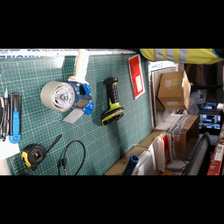

/app/packtisch/square_frames/2024-09-23_14-17-19_cam2/2000.png


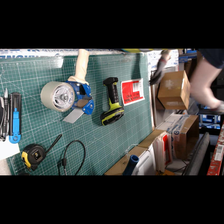

/app/packtisch/square_frames/2024-09-23_14-17-19_cam2/2100.png


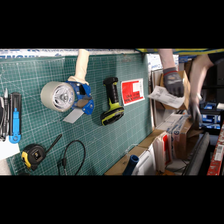

/app/packtisch/square_frames/2024-09-23_14-17-19_cam2/2200.png


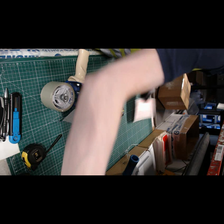

/app/packtisch/square_frames/2024-09-23_14-17-19_cam2/2300.png


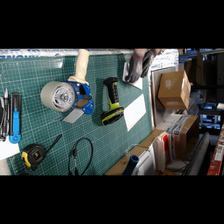

/app/packtisch/square_frames/2024-09-23_14-17-19_cam2/2400.png


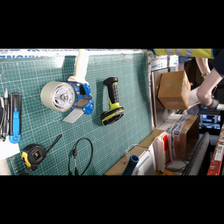

/app/packtisch/square_frames/2024-09-23_14-17-19_cam2/2500.png


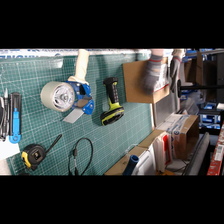

/app/packtisch/square_frames/2024-09-23_14-17-19_cam2/2600.png


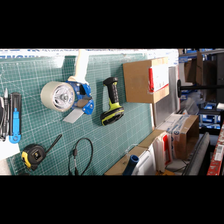

/app/packtisch/square_frames/2024-09-23_14-17-19_cam2/2700.png


In [20]:
folder_name = "/app/packtisch/square_frames/2024-09-23_14-17-19_cam2"
frame_names = [
    os.path.join(folder_name, frame_name)
    for frame_name in sorted(os.listdir(folder_name))
]
for fn in frame_names[::100]:
    Image.open(fn).show()
    print(fn)

# look at /app/packtisch/frames/2024-09-23_14-17-19_cam2/1400.jpg

## Clip objects from scene to ease classification

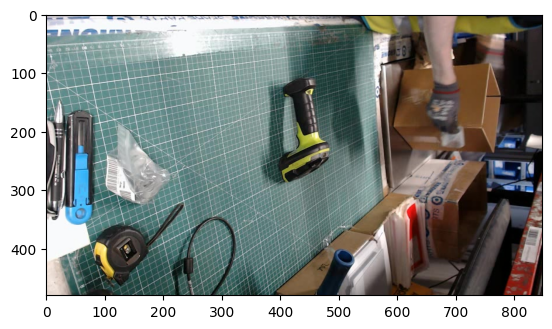

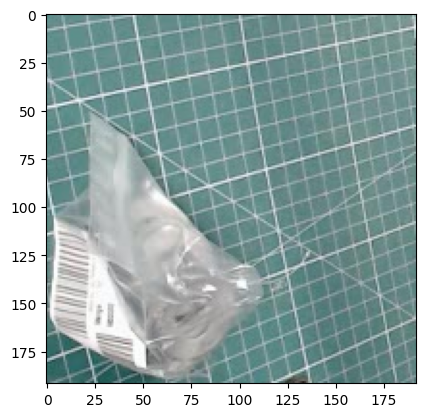

In [64]:
img = np.array(
    Image.open("/app/packtisch/frames/2024-09-23_14-17-19_cam2/1120.jpg").convert("RGB")
)
plt.imshow(img)
plt.show()

offset = 192
x, y = 135, 100
cropped_img = img[x : x + offset, y : y + offset, :]
plt.imshow(cropped_img)
plt.show()

In [65]:
cropped_file_name = "/app/packtisch/cutouts_192/2024-09-23_14-17-19_cam2/1120_v1.jpg"
Image.fromarray(cropped_img).save(cropped_file_name)

## Pad images for segmentation to square shape

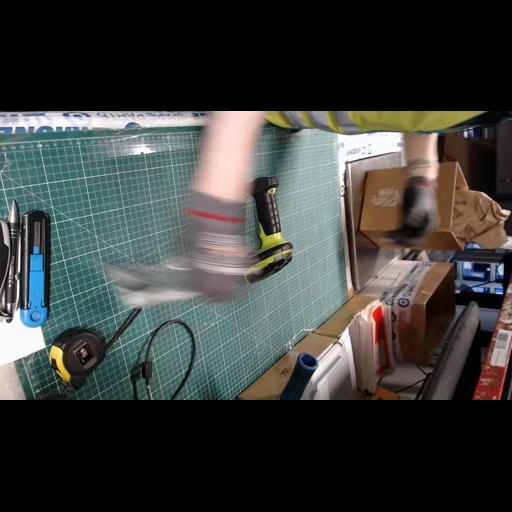

In [35]:
def preprocess_with_padding(image, target_size):
    """
    Preprocess an image to fit a square shape while keeping the aspect ratio.
    Adds black padding when needed.
    
    Args:
        image (PIL.Image.Image): Input image.
        target_size (int): Target square size (e.g., 512).
    
    Returns:
        PIL.Image.Image: Preprocessed image with a square shape.
    """
    # Convert the image to a NumPy array
    image_array = np.array(image)
    
    # Get original dimensions
    original_height, original_width = image_array.shape[:2]
    
    # Calculate the scaling factor to fit the target size
    scale = min(target_size / original_width, target_size / original_height)
    
    # Compute the new dimensions
    new_width = int(original_width * scale)
    new_height = int(original_height * scale)
    
    # Resize the image while maintaining the aspect ratio
    resized_image = image.resize((new_width, new_height), Image.BICUBIC)
    resized_array = np.array(resized_image)
    
    # Create a new blank square canvas (black background)
    padded_image = np.zeros((target_size, target_size, 3), dtype=np.uint8)
    
    # Calculate padding
    pad_top = (target_size - new_height) // 2
    pad_left = (target_size - new_width) // 2
    
    # Place the resized image in the center of the blank canvas
    padded_image[pad_top:pad_top + new_height, pad_left:pad_left + new_width, :] = resized_array
    
    # Convert back to PIL Image
    return Image.fromarray(padded_image)

image = Image.open("/app/packtisch/frames/2024-09-23_14-17-19_cam2/1278.jpg")
target_size = 512
preprocessed_image = preprocess_with_padding(image, target_size)

# Save or visualize the result
preprocessed_image.show()
preprocessed_image.save("/app/packtisch/square_frames_512/2024-09-23_14-17-19_cam2/1278.jpg")